# ResNet 50 Training

## Including the needed libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from scipy.special import softmax

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

/home/ld/anaconda3/envs/dl/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.7.0-dev20210924). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


TensorFlow Version 2.7.0-dev20210924


## Setting the parameters

In [3]:
IMAGE_SIZE = 160
BATCH_SIZE = 16
EPOCHS = 100

train_dir = '../dataset/data/classified'
val_dir = '../dataset/data/validation'
test_dir = '../dataset/data/test'

classes = {0 : "Baby",
           1 : "Not Baby"}

## Defining Data Augmentation Function

In [4]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

## Defining Data Generators

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          preprocessing_function = data_augment)

val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True)


val_test_datagen.apply_transform

train_ds = datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        seed = 1,
        color_mode = 'rgb',
        shuffle = True,
        class_mode='binary')

val_ds = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode = 'rgb',
        shuffle = True,
        class_mode='binary')

test_ds = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode = 'rgb',
        class_mode='binary')

# test_ds = tf.keras.utils.image_dataset_from_directory(
#         test_dir,
#         image_size=(IMAGE_SIZE, IMAGE_SIZE),
#         batch_size=BATCH_SIZE)

Found 97 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


2021-09-26 12:35:19.773980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-26 12:35:19.802993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-26 12:35:19.803453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-26 12:35:19.805011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-26 12:35:19.805428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

(160, 160, 3)


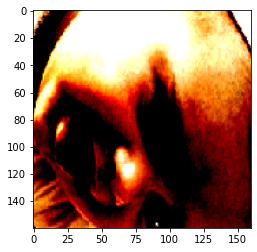

In [6]:
x = train_ds.next()
image = x[0][0]
print(image.shape)
plt.imshow(image)

In [7]:
cat_img = plt.imread('../dataset/data/classified/baby/1.jpeg')

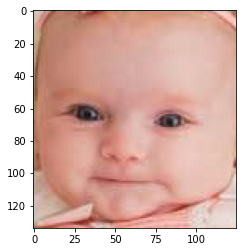

In [8]:
plt.imshow(cat_img)

## Loading the ResNet - 50 Model

In [9]:
res_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), classes=2
)

## Creating the model

In [10]:
model = tf.keras.Sequential([
        res_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(16, activation = "relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, 'sigmoid')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 batch_normalization (BatchN  (None, 51200)            204800    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 16)                819216    
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)          

## Defining Callbacks

In [12]:
learning_rate = 1e-4

optimizer = tf.optimizers.Adam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.binary_crossentropy, 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_ds.n // train_ds.batch_size
# STEP_SIZE_VALID = val_ds.n // val_ds.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 10,
#                                                  verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 30,
                                                 mode = 'max',
#                                                  verbose = 1,
                                                 restore_best_weights = True)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model_res.hdf5',
                                                  monitor = 'val_accuracy', 
#                                                   verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [checkpointer, earlystopping] #reduce_lr earlystopping



## Training the Model

In [13]:
model.fit(x = train_ds,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = val_ds,
          epochs = EPOCHS,
          callbacks = callbacks)

model.save('model_res.h5')

Epoch 1/100


2021-09-26 12:36:04.153510: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


6/6 [==============================] - 13s 800ms/step - loss: 0.7284 - accuracy: 0.6420 - val_loss: 0.6739 - val_accuracy: 0.6154
Epoch 2/100
6/6 [==============================] - 1s 224ms/step - loss: 0.3767 - accuracy: 0.8148 - val_loss: 0.6812 - val_accuracy: 0.5769
Epoch 3/100
6/6 [==============================] - 2s 265ms/step - loss: 0.3760 - accuracy: 0.8125 - val_loss: 0.6871 - val_accuracy: 0.6154
Epoch 4/100
6/6 [==============================] - 1s 227ms/step - loss: 0.2353 - accuracy: 0.9012 - val_loss: 0.8186 - val_accuracy: 0.6154
Epoch 5/100
6/6 [==============================] - 1s 231ms/step - loss: 0.2917 - accuracy: 0.8889 - val_loss: 0.8119 - val_accuracy: 0.6154
Epoch 6/100
6/6 [==============================] - 1s 230ms/step - loss: 0.2131 - accuracy: 0.9506 - val_loss: 0.7079 - val_accuracy: 0.6154
Epoch 7/100
6/6 [==============================] - 2s 362ms/step - loss: 0.1839 - accuracy: 0.9506 - val_loss: 0.6300 - val_accuracy: 0.7308
Epoch 8/100
6/6 [=======

In [15]:
# test_model = tf.keras.models.load_model("./Models/best_model.h5")

In [16]:
# test_model.evaluate(test_ds)

## Evaluating the model on test set

In [14]:
model.evaluate(test_ds)

2/2 [==============================] - 1s 435ms/step - loss: 0.8130 - accuracy: 0.6667


[0.8129585385322571, 0.6666666865348816]

In [18]:
res = model.predict(test_ds)

In [19]:
res

array([[0.9755358 ],
       [0.87546635],
       [0.05417393],
       [0.63265073],
       [0.9689089 ],
       [0.1931679 ],
       [0.13536948],
       [0.35692495],
       [0.6747467 ],
       [0.89792514],
       [0.20051332],
       [0.97407496],
       [0.92489886],
       [0.21409726],
       [0.05386358],
       [0.983214  ],
       [0.26398355],
       [0.99903893]], dtype=float32)

In [20]:
res[res >= 0.5] = 1

In [21]:
res[res < 0.5] = 0

In [22]:
res

array([[1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.]], dtype=float32)

In [23]:
# test_ds